In [39]:
### ---------------------------------------------------------------------------------------------------------------- ###
### AONN - Curve Fitting                                                                                             ###
### Author: Anderson Xu                                                                                              ###
### ---------------------------------------------------------------------------------------------------------------- ###

# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [40]:
### ---------------------------------------------------------------------------------------------------------------- ###
### User Input Section                                                                                               ###
### ---------------------------------------------------------------------------------------------------------------- ###
# please provide the path the main results folder after you run the EIT Analysis tool
results_file_path = r'C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Data 2024\Apr 16 2024\5X5 Trans5 50mm cell 130C 290MHz 3037MHz\Results 2'

# define the type of curve fitting function
# choose from the list below to indicate the type of curve fitting function
# 1. concave up exponential
# 2. concave down exponential
function_type = 1
### ---------------------------------------------------------------------------------------------------------------- ###

In [41]:
### ---------------------------------------------------------------------------------------------------------------- ###
### Function Definitions                                                                                             ###
### ---------------------------------------------------------------------------------------------------------------- ###
# Read the csv file and return the data as numpy arrays, ignore the first row, store the first column as x and the second column as y
def read_csv_file(file_path):
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1)
    x = data[:, 0]
    y = data[:, 1]
    return x, y

def concave_up_exponential(x, a, b, c):
    return a*np.exp(b*x) + c
    
def concave_down_exponential(x, a, b, c):
    # b corresponds to OD in the NN reference file
    # c corresponds to g in the NN reference file
    return a*np.exp(-b * c / (c + 12800*x))

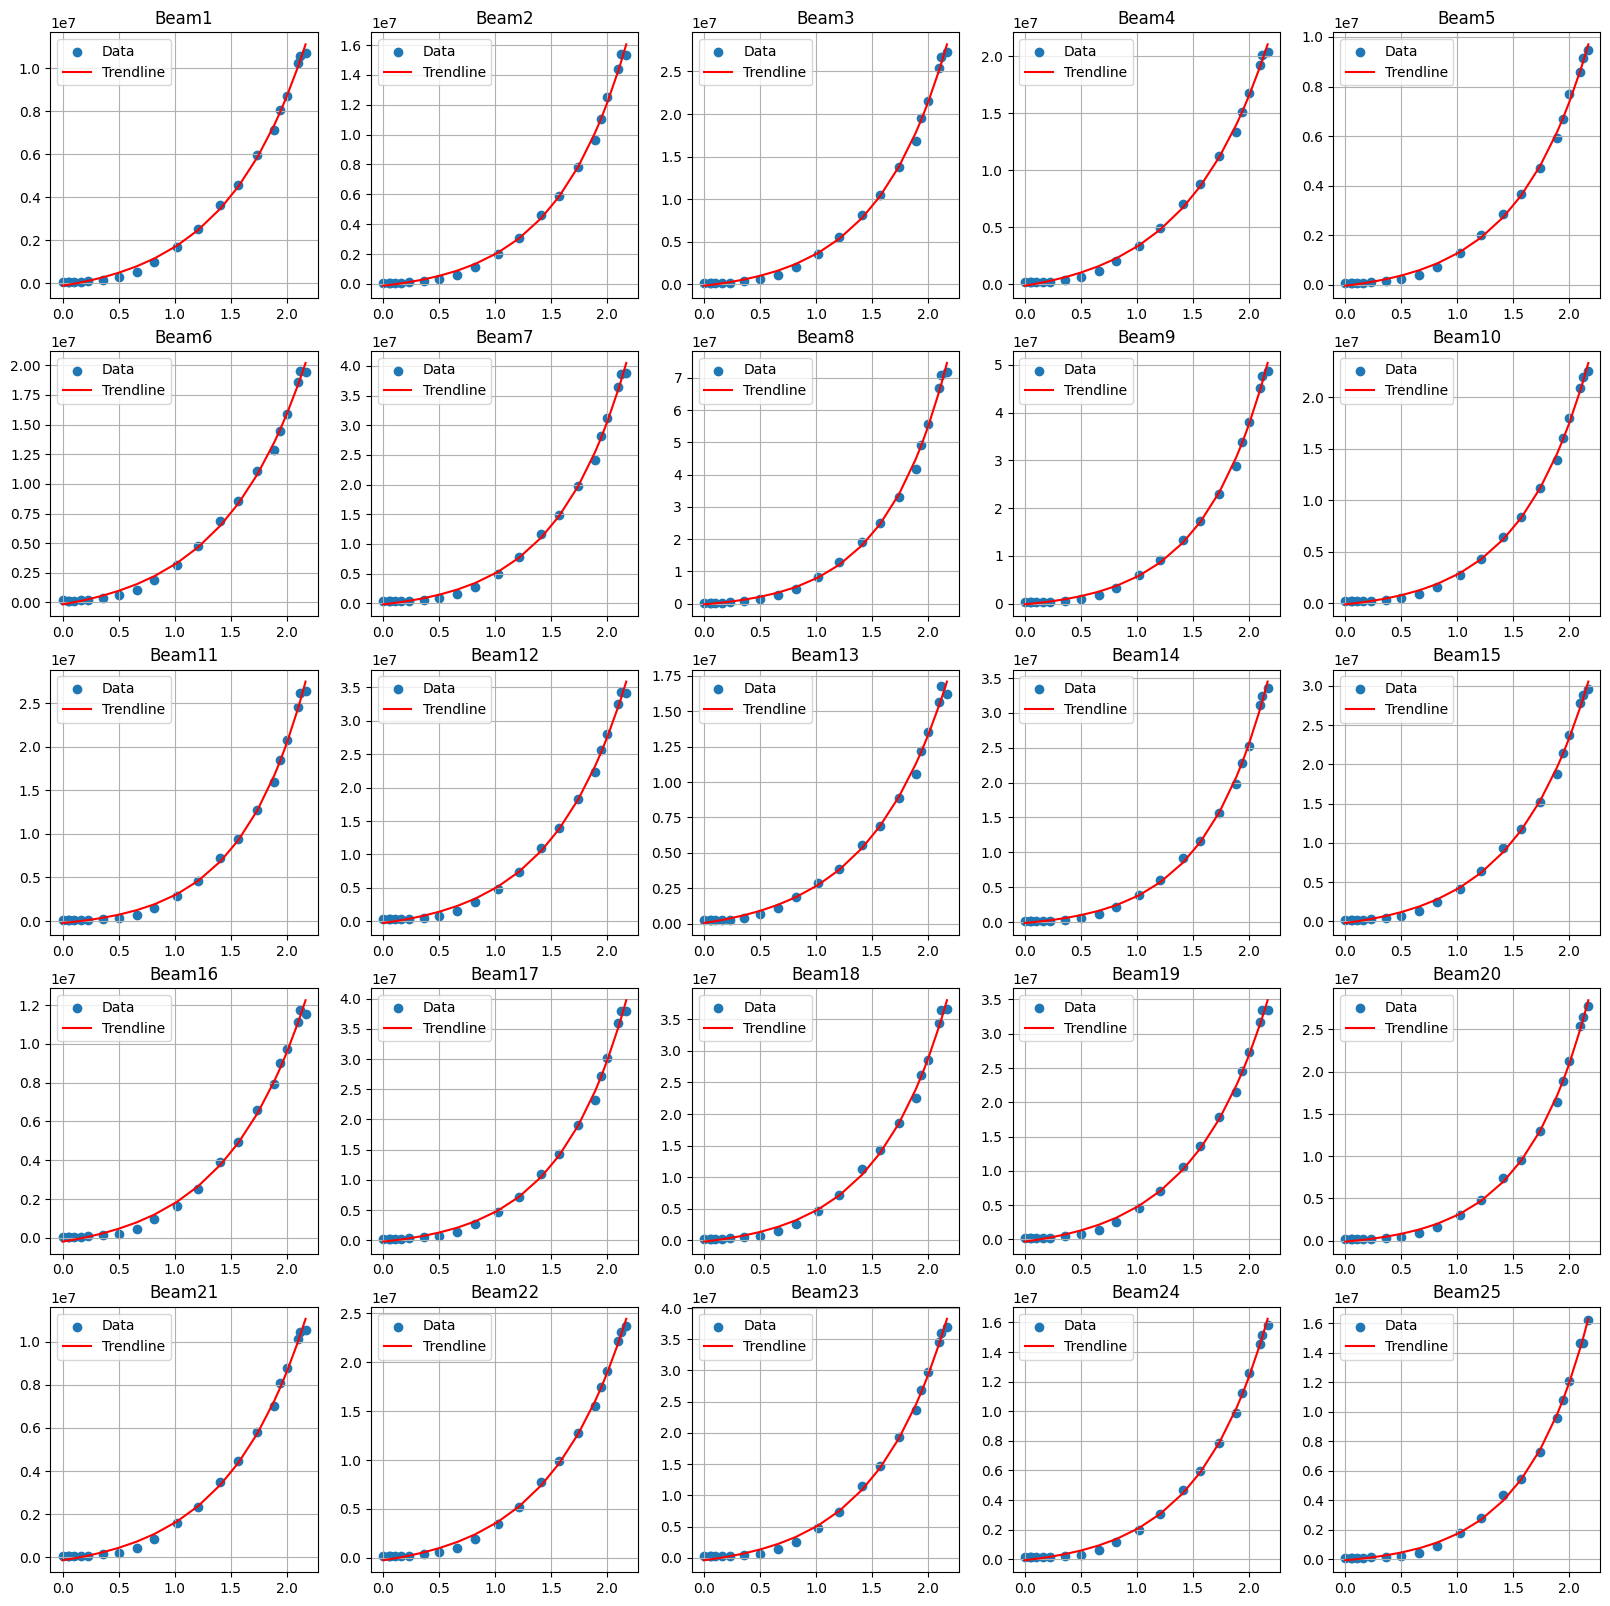

In [42]:
### ---------------------------------------------------------------------------------------------------------------- ###
### Main Code                                                                                                        ###
### ---------------------------------------------------------------------------------------------------------------- ###

# File path handling
# Inside the results file path, there are 20 folders, each containing a csv file
folder_names = [f'Beam{i}' for i in range(1, 26)]
csv_file_name = [f'EIT_Intensity_Beam{i}.csv' for i in range(1, 26)]
# Using the results file path and the names defined above, we can define the full path to the csv files in a loop
full_csv_file_paths = [os.path.join(results_file_path, folder_name, csv_file_name) for folder_name, csv_file_name in zip(folder_names, csv_file_name)]

# Read the csv files and store the data in an array
data = {}
parameters = {}

for i, full_csv_file_path in enumerate(full_csv_file_paths):
    x, y = read_csv_file(full_csv_file_path)
    data[f'Beam{i+1}'] = (x, y)

# arrays to store the optimized parameters
a_values = np.zeros(25)
b_values = np.zeros(25)
c_values = np.zeros(25)

# Define the curve fitting function based on the user input using a switch
if function_type == 1:
    for key, value in data.items():
        x, y = value
        parameters, _ = curve_fit(concave_up_exponential, x, y)
        a_opt, b_opt, c_opt = parameters
        trendline_y = concave_up_exponential(x, a_opt, b_opt, c_opt)
        data[key] = (x, y, trendline_y)
        a_values[int(key[4:])-1] = a_opt
        b_values[int(key[4:])-1] = b_opt
        c_values[int(key[4:])-1] = c_opt
elif function_type == 2:
    for key, value in data.items():
        x, y = value
        parameters, _ = curve_fit(concave_down_exponential, x, y)
        a_opt, b_opt, c_opt = parameters
        a_values[int(key[4:])-1] = a_opt
        b_values[int(key[4:])-1] = b_opt
        c_values[int(key[4:])-1] = c_opt
        trendline_y = concave_down_exponential(x, a_opt, b_opt)
        data[key] = (x, y, trendline_y)
else:
    raise ValueError('Invalid function type')


# Plotting

# Equation for the logarithmic trendline
# equation = f'y = {a_opt:.4f}*exp(- 3* {b_opt:.4f}*12 / ({b_opt:.4f}*12 + 12800*x))'

# for each data set, plot the data and the trendline in a subplot
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i, (key, value) in enumerate(data.items()):
    x, y, trendline_y = value
    row = i // 5
    col = i % 5
    axs[row, col].scatter(x, y, label='Data')
    axs[row, col].plot(x, trendline_y, color='red', label='Trendline')
    axs[row, col].set_title(key)
    axs[row, col].legend()
    axs[row, col].grid(True)



In [43]:
# store the optimized parameters in a csv file
# create a csv file to store the optimized parameters
csv_file_name = 'Optimized_Curve_Fitting_Parameters.csv'
csv_file_path = os.path.join(results_file_path, csv_file_name)
with open(csv_file_path, 'w') as file:
    file.write('Beam, a, b, c\n')
    for i in range(25):
        file.write(f'Beam{i+1}, {a_values[i]:.4f}, {b_values[i]:.4f}, {c_values[i]:.4f}\n')